Null Hypothesis: As Stringency Index increases, Netflix share prices are more inclined to rise.

Alternative hypothesis: Stringency Index has no effect on Netflix share prices.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384044 entries, 0 to 384043
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    384044 non-null  object 
 1   continent                                   365595 non-null  object 
 2   location                                    384044 non-null  object 
 3   Date                                        384044 non-null  object 
 4   total_cases                                 344917 non-null  float64
 5   new_cases                                   372892 non-null  float64
 6   new_cases_smoothed                          371662 non-null  float64
 7   total_deaths                                322777 non-null  float64
 8   new_deaths     

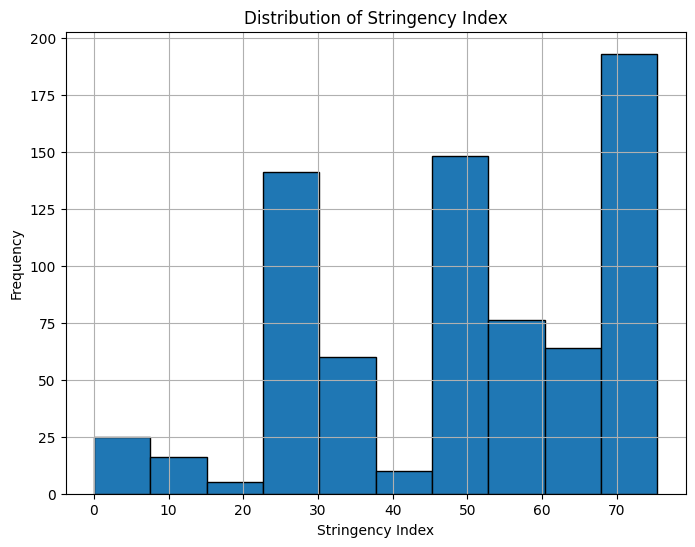

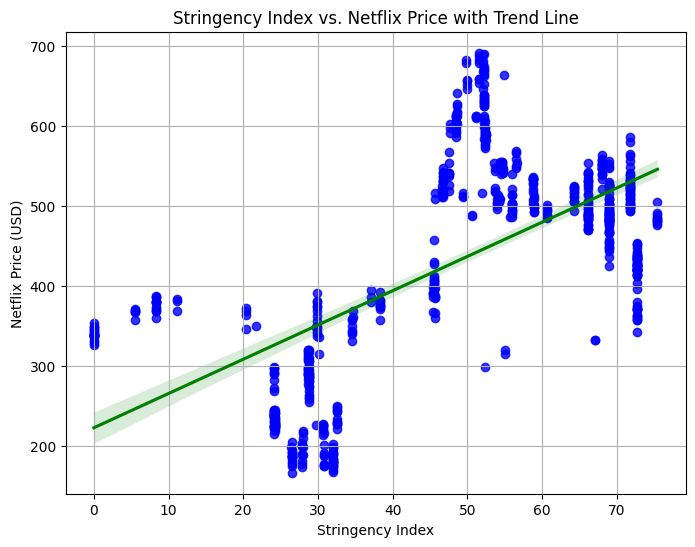

Correlation Coefficient (NFLX share price): 0.6338968515701606
P-value (NFLX share price): 3.4530594227513797e-84


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# Load the Stringency Index data
stringency_data = pd.read_csv("/content/drive/MyDrive/CS210/owid-covid-data.csv")

# Load the US Stocks data
us_stocks_data = pd.read_csv("/content/drive/MyDrive/CS210/Stock Market Dataset.csv")

# 1. Data Cleaning and Preparation

# Inspect both datasets
print(stringency_data.info())
print(us_stocks_data.info())

# Check for missing values
print(stringency_data.isnull().sum())
print(us_stocks_data.isnull().sum())

# Replace empty strings with NaN
stringency_data.replace("", np.nan, inplace=True)
us_stocks_data.replace("", np.nan, inplace=True)

# Handle missing values
stringency_data.dropna(subset=["stringency_index"], inplace=True)
us_stocks_data.dropna(subset=["Netflix_Price"], inplace=True)

us_stocks_data['Date'] = pd.to_datetime(us_stocks_data['Date'], format='%d-%m-%Y')

# Ensure consistent date format and granularity
stringency_data["Date"] = pd.to_datetime(stringency_data["Date"])
us_stocks_data["Date"] = pd.to_datetime(us_stocks_data["Date"])

#I changed it so that the stringency index data only includes the USA.
usa_stringency_data = stringency_data[stringency_data["iso_code"] == "USA"]

# Merge the datasets based on the "Date" column
premerged_data = pd.merge(usa_stringency_data, us_stocks_data, on="Date")
#I made it so that merged_data only includes these 3 variables and doesn't include Crude Oil Prices
#because I decided that 2 different variables to compare with is too much for ML side of the project. Crude Oil data is not considered in my project anymore.
merged_data = premerged_data.filter(['Date', 'stringency_index', 'Netflix_Price'])

# Now you can define X_oil and y_oil using merged_data
X_nflx = merged_data[["stringency_index"]]
y_nflx = merged_data["Netflix_Price"]

# 2. Exploratory Data Analysis and Visualization

# Descriptive statistics for Stringency Index
print(merged_data["stringency_index"].describe())

# Histogram of Stringency Index
plt.figure(figsize=(8,6))
plt.hist(merged_data["stringency_index"], bins=10, edgecolor="black")
plt.xlabel("Stringency Index")
plt.ylabel("Frequency")
plt.title("Distribution of Stringency Index")
plt.grid(True)
plt.show()

# Scatter plot with regression line for Stringency Index vs. Netflix Price
plt.figure(figsize=(8,6))
sns.regplot(x="stringency_index", y="Netflix_Price", data=merged_data, color="blue", marker="o", line_kws={"color":"green"})
plt.xlabel("Stringency Index")
plt.ylabel("Netflix Price (USD)")
plt.title("Stringency Index vs. Netflix Price with Trend Line")
plt.grid(True)
plt.show()

# 3. Hypothesis Testing
# Correlation Test
corr_Netflix, p_value_Netflix = pearsonr(merged_data["stringency_index"],
                                       merged_data["Netflix_Price"])
print("Correlation Coefficient (NFLX share price):", corr_Netflix)
print("P-value (NFLX share price):", p_value_Netflix)

# 4. Linear Regression Modeling
# Model 2: Stringency Index vs. Netflix Price
X_remote = merged_data[["stringency_index"]]  # Independent variable
y_remote = merged_data["Netflix_Price"]       # Dependent variable

# Split data for the remote work model
X_train_remote, X_test_remote, y_train_remote, y_test_remote = train_test_split(X_remote, y_remote, test_size=0.2, random_state=42)

In [17]:
# Model training
model_nflx = LinearRegression()
model_nflx.fit(X_train_remote, y_train_remote)  # Train the model for Netflix Price

# Prediction on test sets
y_pred_nflx = model_nflx.predict(X_test_remote)  # Predict Netflix Price on the test set

In [18]:
# Performance metrics
mse_nflx = mean_squared_error(y_test_remote, y_pred_nflx)
r2_nflx = r2_score(y_test_remote, y_pred_nflx)

print("\nNetflix Price Model:")
print("Mean Squared Error:", mse_nflx)
print("R-squared:", r2_nflx)


Netflix Price Model:
Mean Squared Error: 10693.544769154656
R-squared: 0.35211239478167866


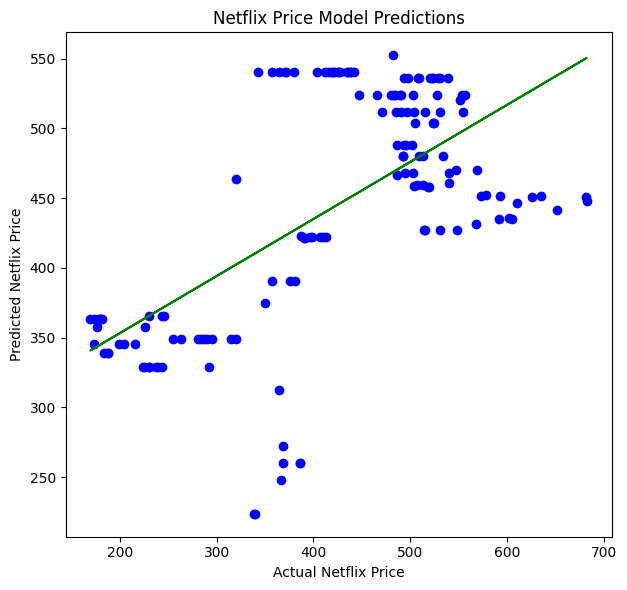

In [19]:
# Visualization with regression line
plt.figure(figsize=(12, 6))

# Netflix Price Model
plt.subplot(1, 2, 2)
plt.scatter(y_test_remote, y_pred_nflx, color='blue')
plt.xlabel("Actual Netflix Price")
plt.ylabel("Predicted Netflix Price")
plt.title("Netflix Price Model Predictions")

# Add regression line
z = np.polyfit(y_test_remote, y_pred_nflx, 1)
p = np.poly1d(z)
plt.plot(y_test_remote, p(y_test_remote), color='green')

plt.tight_layout()
plt.show()

In [20]:
# Example: Predicting price for a given Stringency Index value
new_stringency_index = 15

predicted_nflx_price = model_nflx.predict([[new_stringency_index]])[0]

print("Predicted Netflix Price:", predicted_nflx_price)

Predicted Netflix Price: 289.0773688636824


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
cols_to_normalize = ['Netflix_Price', 'stringency_index']
# Select the columns to scale
cols_to_scale = cols_to_normalize  # You can use the same list from previous scalers

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Create a copy of the merged_data to normalize
merged_data2 = merged_data.copy()

# Fit and transform the selected columns
merged_data2[cols_to_normalize] = scaler.fit_transform(merged_data2[cols_to_normalize])

# Display the first few rows of the new dataset
print(merged_data2.head())

        Date  stringency_index  Netflix_Price
0 2020-01-06               0.0       0.322584
1 2020-01-07               0.0       0.312914
2 2020-01-08               0.0       0.329114
3 2020-01-09               0.0       0.322261
4 2020-01-10               0.0       0.309678


Optimal number of neighbors: 3
Root Mean Squared Error for optimal k: 0.05708781281185579


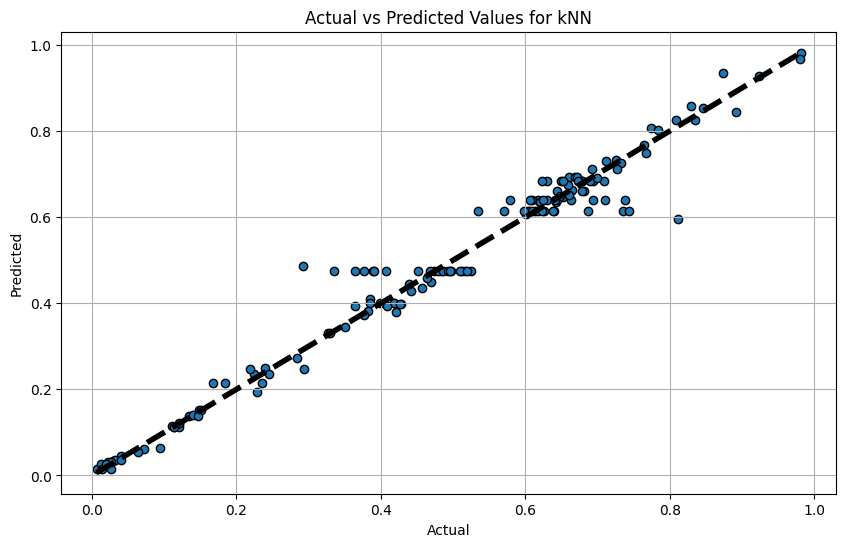

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the feature and target variable
X = merged_data2[['stringency_index']]
y = merged_data2['Netflix_Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Find the optimal number of neighbors using cross-validation
min_rmse = float('inf')
optimal_k = 1
rmse_values = []

for k in range(1, 49):
    knn = KNeighborsRegressor(n_neighbors=k)
    # Perform cross-validation and calculate the mean RMSE
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores.mean())
    rmse_values.append(rmse)
    if rmse < min_rmse:
        min_rmse = rmse
        optimal_k = k

print(f'Optimal number of neighbors: {optimal_k}')
print(f'Root Mean Squared Error for optimal k: {min_rmse}')

import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values for kNN')
plt.grid(True)
plt.show()

Random Forest Regression RMSE: 0.0424969944383886
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Actual: 0.6437409578923322, Predicted: 0.6603316907440874
Actual: 0.6424084367623543, Predicted: 0.6345014467372277
Actual: 0.6303776745602679, Predicted: 0.683416820466861
Actual: 0.4272253102870631, Predicted: 0.39892313256681666
Actual: 0.6137973045001142, Predicted: 0.6143286596814148
Actual: 0.6777773547551967, Predicted: 0.683416820466861
Actual: 0.14798598949211905, Predicted: 0.15172812535125985
Actual: 0.6786149394654686, Predicted: 0.683416820466861
Actual: 0.8295134394273966, Predicted: 0.8579353536891803
Actual: 0.834139191350034, Predicted: 0.8244272062742718
[1.]


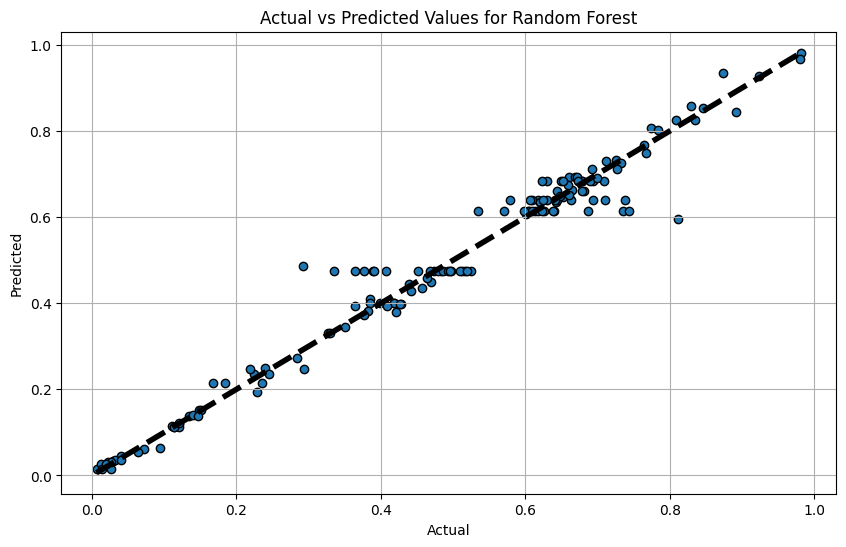

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Define the feature and target variable
X = merged_data2[['stringency_index']]
y = merged_data2['Netflix_Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest Regressor with GridSearchCV for hyperparameter tuning
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best estimator
best_rf = grid_search.best_estimator_

# Predict on the test data with the best model
y_pred = best_rf.predict(X_test)

# Evaluate the best RandomForest Regressor model
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Random Forest Regression RMSE: {rf_rmse}')
print(f'Best parameters: {grid_search.best_params_}')

# Optional: Print the first few predictions vs actual values
for i in range(10):
    print(f'Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}')

# Plot the RMSE values for different parameter combinations
results = pd.DataFrame(grid_search.cv_results_)
scores = np.sqrt(-results['mean_test_score'])
print(best_rf.feature_importances_)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values for Random Forest')
plt.grid(True)
plt.show()